In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.optim.lr_scheduler as lr_scheduler
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from PIL import Image
from torchsummary import summary

In [2]:
img_size = 224
my_batch_size = 64
epochs_num = 50
learning_rate = 1e-3

In [3]:
class MyImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_size=(300, 400), target_transform=None):
    # def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_excel(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_size = target_size
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 2])
        image = Image.open(img_path)
        
        image = image.resize(self.target_size)
        # image = image.numpy()
        label = self.img_labels.iloc[idx, 0]
        # label = self.img_labels.iloc[idx, 1] # 1 - prices, 0 - names
        # label = self.transform(label)
        if self.transform:
            image = self.transform(image)
            # label = self.transform(label)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
my_transform = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor()
                                #    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                   ])

In [5]:
train_set = MyImageDataset('train_data.xlsx', 'train_imgs_augm/', transform=my_transform)
test_set = MyImageDataset('test_data.xlsx', 'test_imgs/', transform=my_transform)

In [6]:
print(len(train_set))
print(len(test_set))

6512
93


In [7]:
train_dataloader = DataLoader(train_set, batch_size=my_batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=my_batch_size, shuffle=True)

In [8]:
print(type(train_dataloader))
print(type(test_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [9]:
# train_dataloader = DataLoader(my_set, batch_size=16, shuffle=True)
train_dataloader.dataset

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Type of y: <class 'torch.Tensor'>


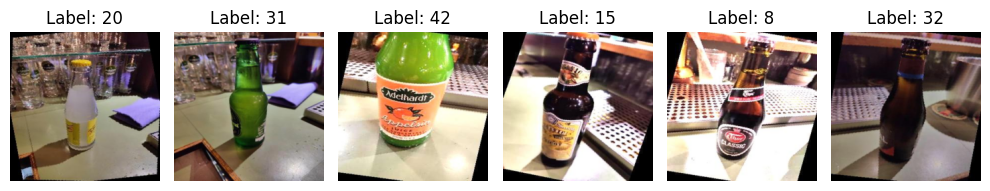

In [10]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Type of y: {type(y)}")
    

    fig, axes = plt.subplots(1, 6, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(6):
        img = np.transpose(X[i].squeeze(0), (1, 2, 0))
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {y[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    break

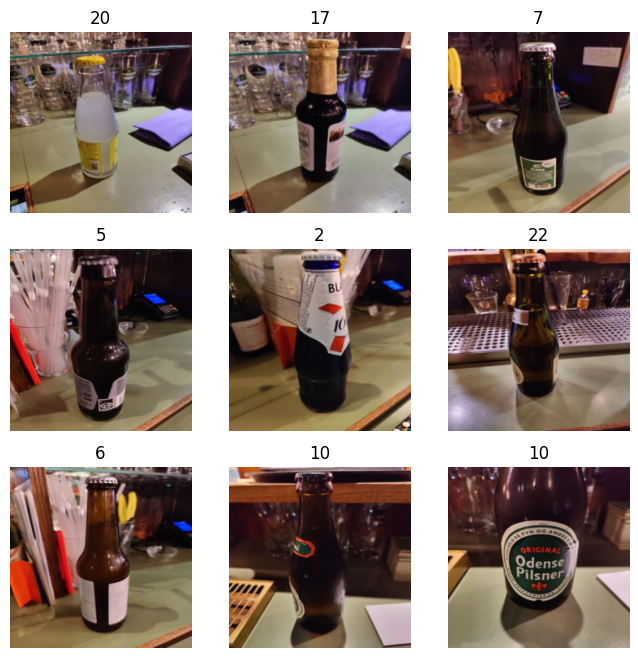

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataloader), size=(1,)).item()
    img, label = train_dataloader.dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    # print(type(label))
    plt.axis("off")
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.show()

In [12]:
device = (
    "cuda" if torch.cuda.is_available()
     else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [13]:
if img_size == 112:
    fc1_inp_size = 12800
elif img_size == 224:
    fc1_inp_size = 73728
else:
    fc1_inp_size = 512

print(fc1_inp_size)

73728


In [14]:
class BeerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='valid')
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='valid')
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding='valid')
        self.relu  = nn.ReLU(inplace=True)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1   = nn.Linear(fc1_inp_size, 512) # img_size = 56: 512 img_size=112: 12800, img_size = 224: 73728
        self.fc2   = nn.Linear(512, 256)
        self.fc3   = nn.Linear(256, 128)
        self.fc4   = nn.Linear(128, 48)

    def forward(self, x):
      x = self.conv1(x) 
      x = self.relu(x)
      x = self.pool(x)
      
      x = self.conv2(x)
      x = self.relu(x)
      x = self.pool(x)
      
      x = self.conv3(x)
      x = self.relu(x)
      x = self.pool(x)
      
      x = self.conv4(x)
      x = self.relu(x)
      x = self.pool(x)
      
      x = self.flatten(x)
      
      x = self.fc1(x)
      x = self.relu(x)
      
      x = self.fc2(x)
      x = self.relu(x)

      x = self.fc3(x)
      x = self.relu(x)
      
      x = self.fc4(x)
      return x


model = BeerModel().to(device)
print(model)

BeerModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=73728, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=48, bias=True)
)


In [15]:
summary(model, input_size=(3, img_size, img_size), device=device)


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,792
├─Conv2d: 1-2                            73,856
├─Conv2d: 1-3                            295,168
├─Conv2d: 1-4                            1,180,160
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            37,749,248
├─Linear: 1-9                            131,328
├─Linear: 1-10                           32,896
├─Linear: 1-11                           6,192
Total params: 39,470,640
Trainable params: 39,470,640
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,792
├─Conv2d: 1-2                            73,856
├─Conv2d: 1-3                            295,168
├─Conv2d: 1-4                            1,180,160
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            37,749,248
├─Linear: 1-9                            131,328
├─Linear: 1-10                           32,896
├─Linear: 1-11                           6,192
Total params: 39,470,640
Trainable params: 39,470,640
Non-trainable params: 0

In [16]:
loss_fn = nn.CrossEntropyLoss() #ignore_index=0, reduction='sum'
# loss_fn = nn.MSELoss(reduction='mean')
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# try with Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=2)

In [17]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss, correct = 0, 0  # Track the total loss for the epoch

    for batch, (X, y) in enumerate(dataloader):
    # for X, y in dataloader.dataset:
        # print(X, y)
        X, y = X.to(device), y.to(device)
        # X = X.to(device)
        # Compute prediction error
        pred = model(X)
        
        # loss = loss_fn(pred, torch.Tensor(y))
        loss = loss_fn(pred, y)
        total_loss += loss.item()  # Accumulate loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Calculate accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")      
    avg_loss = total_loss / len(dataloader)  # Calculate average loss for the epoch
    avg_accuracy = correct / size

    train_losses.append(avg_loss)  # Store the average loss for the epoch
    train_accuracies.append(avg_accuracy) # Store the average accuracy for the epoch

    print(f"Train loss: {avg_loss:>7f}, Accuracy: {100*(avg_accuracy):>0.1f}%")


In [18]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_losses.append(test_loss)  # Store the test loss for the epoch
    test_accuracies.append(correct)

    print(f"Test Error: \n Avg loss: {test_loss:>8f}, Accuracy: {100*(correct):>0.1f}% \n")
    return correct #test_loss

In [19]:
epochs = epochs_num
patience = 5
count_early_stop = 0
# best_loss = float('inf')
best_acc = float('-inf')
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(train_dataloader, model, loss_fn, optimizer)
    current_test_acc = test(test_dataloader, model, loss_fn)
    
    # if current_test_loss < best_loss:
    #     best_loss = current_test_loss
    #     count_early_stop = 0
    #     print(f"Test loss improved to {best_loss:.6f}, saving model...")
    #     torch.save(model.state_dict(), 'best_model.pth')
    if current_test_acc > best_acc:
        best_acc = current_test_acc
        count_early_stop = 0
        print(f"Accuracy improved to {best_acc:.6f}, saving model...")
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        count_early_stop += 1
        print(f"Early stopping counter: {count_early_stop}/{patience}")
        
    if count_early_stop >= patience:
        print("Stopping early")
        epochs = t+1
        break
    
print("Done!")


Epoch 1
Train loss: 2.891820, Accuracy: 23.0%
Test Error: 
 Avg loss: 1.151700, Accuracy: 61.3% 

Accuracy improved to 0.612903, saving model...
Epoch 2
Train loss: 0.381182, Accuracy: 87.9%
Test Error: 
 Avg loss: 0.644002, Accuracy: 84.9% 

Accuracy improved to 0.849462, saving model...
Epoch 3
Train loss: 0.079167, Accuracy: 97.9%
Test Error: 
 Avg loss: 0.537093, Accuracy: 89.2% 

Accuracy improved to 0.892473, saving model...
Epoch 4
Train loss: 0.071613, Accuracy: 98.3%
Test Error: 
 Avg loss: 0.486013, Accuracy: 89.2% 

Early stopping counter: 1/5
Epoch 5
Train loss: 0.018319, Accuracy: 99.6%
Test Error: 
 Avg loss: 0.516285, Accuracy: 90.3% 

Accuracy improved to 0.903226, saving model...
Epoch 6
Train loss: 0.047466, Accuracy: 98.9%
Test Error: 
 Avg loss: 0.571970, Accuracy: 89.2% 

Early stopping counter: 1/5
Epoch 7
Train loss: 0.062053, Accuracy: 98.2%
Test Error: 
 Avg loss: 0.377635, Accuracy: 91.4% 

Accuracy improved to 0.913978, saving model...
Epoch 8
Train loss: 0.0

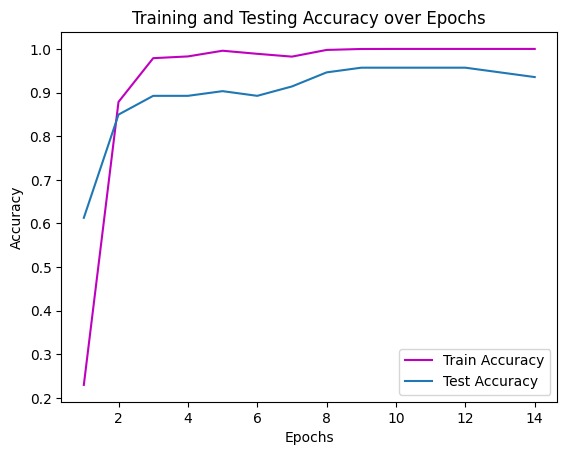

In [20]:
plt.plot(range(1, epochs+1), train_accuracies, 'm' , label="Train Accuracy")
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.show()


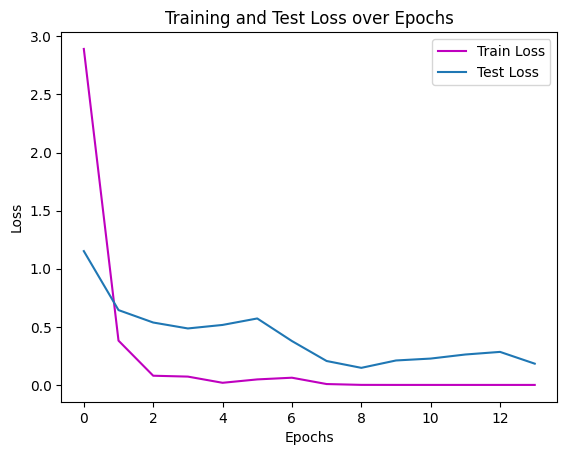

In [21]:
plt.plot(train_losses, 'm', label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.show()

In [22]:
model.eval()

wrong_preds = []

with torch.no_grad():
    for idx in range(len(test_set)):
        x, y = test_set[idx][0], test_set[idx][1]
        x = x.to(device)
        pred = model(x.unsqueeze(0))  # batch dim
        predicted_label = pred[0].argmax(0).item()

        if predicted_label != y:
            wrong_preds.append(idx)

len(wrong_preds)

6

Predicted: "(9, 'odense_classic: 34dkk')", Actual: "(7, 'thor_pilsner: 28dkk')"


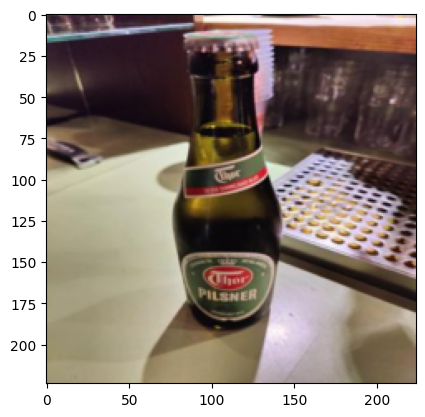

In [31]:
labels_map = {
    0: 'daura: 55dkk', 
    1: 'ginger_beer_without: 45dkk',
    2: 'blanc: 45dkk', 
    3: 'fynsk_foraar: 45dkk', 
    4: 'mokai: 45dkk',
    5: 'punk_ipa_without: 55dkk', 
    6: 'ginger_beer: 55dkk', 
    7: 'thor_pilsner: 28dkk', 
    8: 'thor_classic: 34dkk', 
    9: 'odense_classic: 34dkk', 
    10: 'odense_pilsner: 28dkk', 
    11: 'hazy_jane: 55dkk', 
    12: 'grimbergen_blonde: 45dkk', 
    13: 'grimbergen_double: 45dkk', 
    14: 's_smith_chocolade: 55dkk', 
    15: 's_smith_apricot: 55dkk', 
    16: 'trapist_8: 55dkk', 
    17: 's_smith_stout: 55dkk', 
    18: 'mirinda: 28dkk', 
    19: '7_up: 28dkk', 
    20: 'schweps: 28dkk', 
    21: 'tonic: 28dkk', 
    22: 'tuborg_guld: 40dkk', 
    23: 'blaaa_thor: 40dkk', 
    24: 'ale_nr_16: 40dkk', 
    25: 'ludwig_dunkel: 65dkk', 
    26: 'ludwig_weiss: 65dkk', 
    27: 'sierra_pale_ale: 55dkk', 
    28: 'dansk_vand: 34dkk', 
    29: 'dansk_vand_citron: 34dkk', 
    30: 'blanc_without: 45dkk', 
    31: 'heineken_without: 34dkk', 
    32: 'royal_classic_without: 34dkk', 
    33: 'royal_pilsner_without: 34dkk', 
    34: 'pepsi: 28dkk', 
    35: 'pepsi_max: 28dkk', 
    36: 'ceres_top: 28dkk', 
    37: 'tuborg_groen: 28dkk', 
    38: 'somersby: 45dkk', 
    39: 's_smith_cider: 55dkk', 
    40: 'cocio: 34dkk', 
    41: 'aeble_most: 34dkk', 
    42: 'appelsin_juice: 34dkk', 
    43: 'hyldeblomst_drik: 34dkk', 
    44: 'limfjords_porter: 45dkk', 
    45: 'sierra_torpedo: 45dkk', 
    46: 'tuborg_juleoel: 40dkk', 
    47: 'albani_juleoel: 40dkk'
}

model.eval()
id = 5
idx = wrong_preds[id]
x, y = test_set[idx][0], test_set[idx][1]
plt.imshow(x.permute(1,2,0))
with torch.no_grad():
    x = x.to(device)
    pred = model(x.unsqueeze(0))
    # predicted, actual = classes[pred[0].argmax(0)], classes[y]
    predicted, actual = [pred[0].argmax(0)], [y]
    predicted = predicted[0].item()
    actual = actual[0].item()
    print(f'Predicted: "{predicted, labels_map[predicted]}", Actual: "{actual, labels_map[actual]}"')

In [24]:
model.eval()

correct_preds = []

with torch.no_grad():
    for idx in range(len(test_set)):
        x, y = test_set[idx][0], test_set[idx][1]
        x = x.to(device)
        pred = model(x.unsqueeze(0))  # batch dim
        predicted_label = pred[0].argmax(0).item()

        if predicted_label == y:
            correct_preds.append(idx)

len(correct_preds)

87

Predicted: "(5, 'punk_ipa_without: 55dkk')", Actual: "(5, 'punk_ipa_without: 55dkk')"


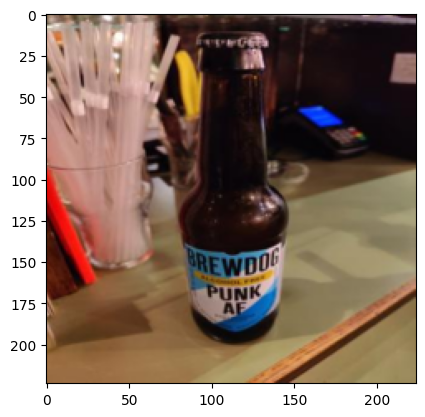

In [ ]:
model.eval()
id = 5
idx = correct_preds[id]
x, y = test_set[idx][0], test_set[idx][1]
plt.imshow(x.permute(1,2,0))
with torch.no_grad():
    x = x.to(device)
    pred = model(x.unsqueeze(0))
    # predicted, actual = classes[pred[0].argmax(0)], classes[y]
    predicted, actual = [pred[0].argmax(0)], [y]
    predicted = predicted[0].item()
    actual = actual[0].item()
    print(f'Predicted: "{predicted, labels_map[predicted]}", Actual: "{actual, labels_map[actual]}"')
    